In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib.dates import date2num
import numpy as np
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean.cm as cmo
import os
from collections import OrderedDict
import matplotlib as mpl
mpl.rcParams['font.size'] = 14
from scipy.optimize import curve_fit
import shapely
import tabs

/anaconda3/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cartopy.feature.COLORS['land'])
pc = cartopy.crs.PlateCarree()
merc = cartopy.crs.Mercator(central_longitude=-85.0)

In [3]:
df = pd.read_csv('../../../../data/HRRO3 March 25-27 2018/SCS_ Pelican/MIDAS/MIDAS_001.elg', parse_dates=[[0,1]], index_col=0, na_values='na', nrows=95000)


In [4]:
#convert from shoved together numbers to decimal degrees by pulling apart number as a string
df.loc[:,'ADU800-GGA-Lat'] = [float(str(la)[:2]) + float(str(la)[2:-1])/60 for la in df['ADU800-GGA-Lat']]
#and again for longitude
df.loc[:,'ADU800-GGA-Lon'] = [-(float(str(lo)[1:3]) + float(str(lo)[3:-1])/60) for lo in df['ADU800-GGA-Lon']]

In [5]:
tdf = tabs.read('g06010', '2018-3-25', '2018-3-27') #g06010 bouy

# Figure without Galveston Bay

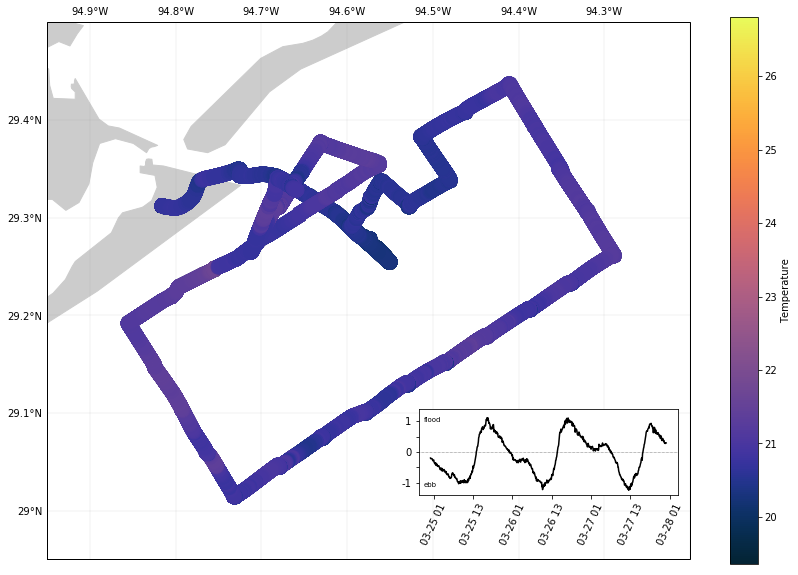

In [6]:
fig = plt.figure(figsize=(12, 8)) # (9.4, 7.7))

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False) 
ax.set_extent([-94.95, -94.2, 28.95, 29.5], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# Lat/Lon Formatter
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_bottom = False 
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

mappable = ax.scatter(df['ADU800-GGA-Lon'], df['ADU800-GGA-Lat'], c=df['Thermosalinograph-Data-Temp'], s=200, cmap=cmo.thermal, transform=pc, zorder=10)
cb = fig.colorbar(mappable)
cb.set_label('Temperature')

#Tidal Bouy
axtide = fig.add_axes([0.49, 0.13, 0.3, 0.15]) 
axtide.plot(tdf['g06010: Along [cm/s]']['2018-3-25':'2018-3-27']/100, color='k') 
axtide.text(0.02, 0.85, 'flood', fontsize=7, transform=axtide.transAxes)
axtide.text(0.02, 0.1, 'ebb', fontsize=7, transform=axtide.transAxes)
axtide.get_yaxis().set_ticks(np.arange(-1,1.5,0.5))
axtide.get_yaxis().set_ticklabels(['-1', '', '0', '', '1'])
axtide.set_ylim(-1.4, 1.4)
plt.xticks(rotation=65)
axtide.axhline(y=0.0, xmin=0, xmax=1, color='k', linestyle=':', linewidth=0.5)

# Ebb Tide Subplots 

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


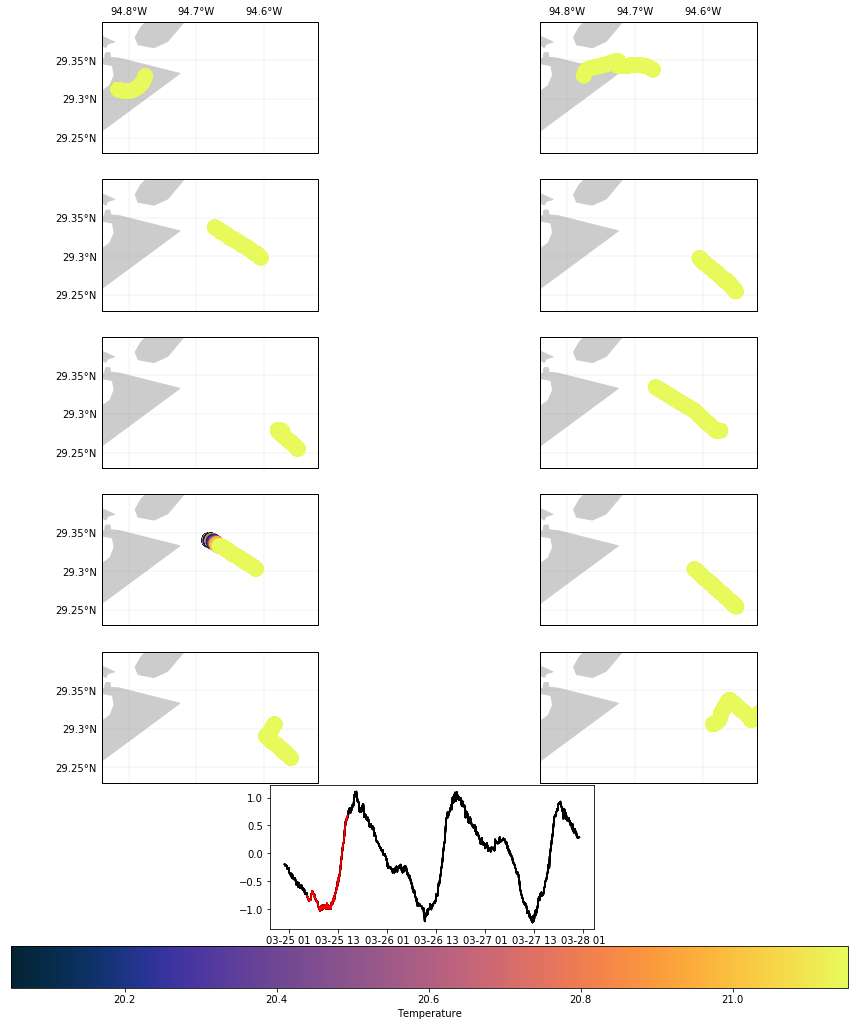

In [7]:
fig, axes = plt.subplots(nrows = 5, ncols = 2,subplot_kw = dict(projection = merc), figsize = (15,20))
dstartoverall = pd.Timestamp('2018-3-25 05:30')
plt.subplots_adjust(wspace = .1) #adjust this for maximum plot space
vmin = df['Thermosalinograph-Data-Temp'][dstartoverall : dstartoverall + pd.Timedelta('10 hour')].min()
vmax = df['Thermosalinograph-Data-Temp'][dstartoverall : dstartoverall + pd.Timedelta('10 hour')].max()

for i,ax in enumerate(axes.flatten()):
    ax.set_extent([-94.84, -94.52, 29.23, 29.4], pc)
    gl = ax.gridlines(linewidth = 0.2, color = 'gray', alpha = 0.5, linestyle = '-', draw_labels = True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlocator = mpl.ticker.FixedLocator(np.arange(-100, -70, .1))
    gl.ylocator = mpl.ticker.FixedLocator(np.arange(10, 40, .05))
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    ax.add_feature(land_10m, facecolor = '0.8')
    ax.set_facecolor('0.8')
    
    # Tidal bouy plot
    axtide = fig.add_axes([0.365, 0.25, 0.3, 0.1]) 
    axtide.plot(tdf['g06010: Along [cm/s]']/100, color='k') 
    Sharey = True
    
    # Adding Edd Tide duration Red Line for Tidal plot
    axtidered = fig.add_axes([0.365, 0.25, 0.3, 0.1]) 
    axtidered.plot(tdf['g06010: Along [cm/s]']['2018-3-25 05:30':'2018-3-25 15:30']/100, color='r') 
    Sharey = True
    
    dstart = dstartoverall + i*pd.Timedelta('1 hour')
    dend = dstart + pd.Timedelta('1 hour') 
    
    if i >= 2:
        gl.xlabels_top = False
    
    if i in [1, 3, 5, 7, 9] : 
        gl.ylabels_left = False
        
    mappable = ax.scatter(df['ADU800-GGA-Lon'][dstart:dend], df['ADU800-GGA-Lat'][dstart:dend], c=df['Thermosalinograph-Data-Salinity'][dstart:dend], s=200, cmap=cmo.thermal, transform=pc, zorder=10, vmin = vmin, vmax = vmax)
cb = fig.colorbar(mappable, orientation = 'horizontal', ax=axes.ravel().tolist())
cb.set_label('Temperature')
    

fig.savefig('testtemp.png')

# Flood Tide

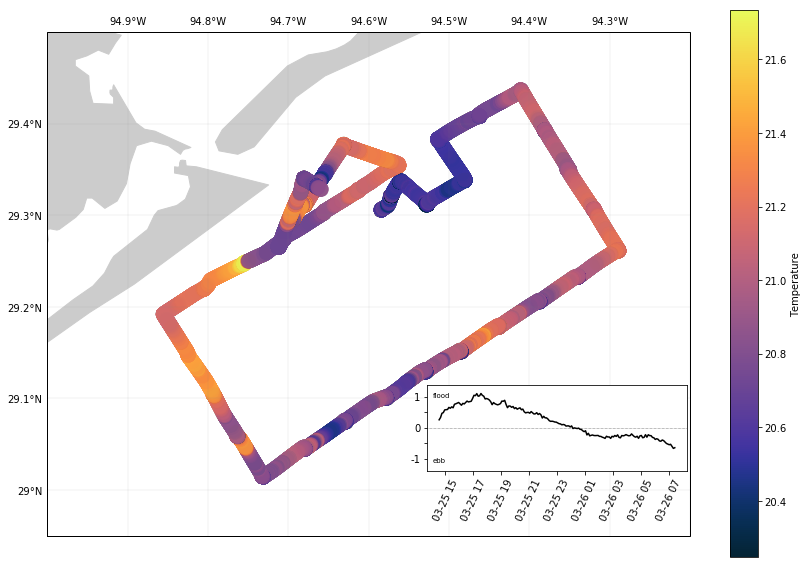

In [8]:
fig = plt.figure(figsize=(12, 8)) 

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=merc)
ax.set_frame_on(False)

# Controls bounds of cruise
ax.set_extent([-95.0, -94.2, 28.95, 29.5], pc)
gl = ax.gridlines(linewidth=0.2, color='gray', alpha=0.5, linestyle='-', draw_labels=True)

# Make the labels look like lat/lon format
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Turn off labels if you don't want them
gl.xlabels_bottom = False 
gl.ylabels_right = False
ax.add_feature(land_10m, facecolor='0.8')
ax.set_facecolor('0.8')

# Colorbar
mappable = ax.scatter(df['ADU800-GGA-Lon']['2018-3-25 14:30':'2018-3-26 07:30'], df['ADU800-GGA-Lat']['2018-3-25 14:30':'2018-3-26 07:30'], c=df['Thermosalinograph-Data-Temp']['2018-3-25 14:30':'2018-3-26 07:30'], s=200, cmap=cmo.thermal, transform=pc, alpha=0.1)
cb = fig.colorbar(mappable)
cb.set_alpha(1)
cb.draw_all()
cb.set_label('Temperature')

# Tidal Bouy
axtide = fig.add_axes([0.5, 0.16, 0.3, 0.15]) 
axtide.plot(tdf['g06010: Along [cm/s]']['2018-3-25 14:30':'2018-3-26 07:30']/100, color='k') 
axtide.text(0.02, 0.85, 'flood', fontsize=7, transform=axtide.transAxes)
axtide.text(0.02, 0.1, 'ebb', fontsize=7, transform=axtide.transAxes)
axtide.get_yaxis().set_ticks(np.arange(-1,1.5,0.5))
axtide.get_yaxis().set_ticklabels(['-1', '', '0', '', '1'])
axtide.set_ylim(-1.4, 1.4)
plt.xticks(rotation=65)
axtide.axhline(y=0.0, xmin=0, xmax=1, color='k', linestyle=':', linewidth=0.5)